In [1]:
# Imports
import numpy as np
import modern_robotics as mr
import matplotlib.pyplot as plt
import os

### Setup of Robot Parameters

In [2]:
def ur5_params():
    M01 = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0.089159], [0, 0, 0, 1]]
    M12 = [[0, 0, 1, 0.28], [0, 1, 0, 0.13585], [-1, 0, 0, 0], [0, 0, 0, 1]]
    M23 = [[1, 0, 0, 0], [0, 1, 0, -0.1197], [0, 0, 1, 0.395], [0, 0, 0, 1]]
    M34 = [[0, 0, 1, 0], [0, 1, 0, 0], [-1, 0, 0, 0.14225], [0, 0, 0, 1]]
    M45 = [[1, 0, 0, 0], [0, 1, 0, 0.093], [0, 0, 1, 0], [0, 0, 0, 1]]
    M56 = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0.09465], [0, 0, 0, 1]]
    M67 = [[1, 0, 0, 0], [0, 0, 1, 0.0823], [0, -1, 0, 0], [0, 0, 0, 1]]
    G1 = np.diag([0.010267495893, 0.010267495893,  0.00666, 3.7, 3.7, 3.7])
    G2 = np.diag([0.22689067591, 0.22689067591, 0.0151074, 8.393, 8.393, 8.393])
    G3 = np.diag([0.049443313556, 0.049443313556, 0.004095, 2.275, 2.275, 2.275])
    G4 = np.diag([0.111172755531, 0.111172755531, 0.21942, 1.219, 1.219, 1.219])
    G5 = np.diag([0.111172755531, 0.111172755531, 0.21942, 1.219, 1.219, 1.219])
    G6 = np.diag([0.0171364731454, 0.0171364731454, 0.033822, 0.1879, 0.1879, 0.1879])
    Glist = [G1, G2, G3, G4, G5, G6]
    Mlist = [M01, M12, M23, M34, M45, M56, M67] 
    Slist = [[0,         0,         0,         0,        0,        0],
            [0,         1,         1,         1,        0,        1],
            [1,         0,         0,         0,       -1,        0],
            [0, -0.089159, -0.089159, -0.089159, -0.10915, 0.005491],
            [0,         0,         0,         0,  0.81725,        0],
            [0,         0,     0.425,   0.81725,        0,  0.81725]]

    # Home configuration M of the end-effector
    M = np.eye(4)
    for Mi in Mlist:
        M = M @ Mi

    # Gravity and end-effector wrench
    g = np.array([0, 0, -9.81])
    # No external end-effector force/torque
    Ftip = np.zeros(6)

    return M, Mlist, Glist, Slist, g, Ftip

### Task 2: Input Parser

In [5]:
def parse_floats_from_line(value_str, expected_count=None):
    """
    Helper fn that to parse space separated list of floats from a string.
    expected_count: check how many numbers expected.
    """
    parts = value_str.strip().split()
    vals = [float(x) for x in parts]
    if expected_count is not None and len(vals) != expected_count:
        raise ValueError(f"Expected {expected_count} floats, got {len(vals)} from: {value_str}")
    return vals

In [6]:
def build_T_from_pos_expcoords(vec6):
    """
    Build an SE(3) T matrix from 6D configuration vector [x, y, z, wx, wy, wz].
    """
    vec6 = np.array(vec6).reshape(6,)
    p = vec6[0:3]
    w = vec6[3:6]

    # Orientation from exponential coordinates
    if np.linalg.norm(w) < 1e-8:
        R = np.eye(3)
    else:
        R = mr.MatrixExp3(mr.VecToso3(w))

    T = np.eye(4)
    T[0:3, 0:3] = R
    T[0:3, 3] = p
    return T

In [7]:
def parse_input(filepath):
    """
    Parse a text input file.

    Returns:
    config : dict
        {
            "Ts_start": 4x4 ndarray,
            "Ts_end": 4x4 ndarray,
            "traj_type": str,
            "Tf": float,
            "theta0": 6 vector ndarray
        }
    """
    if not os.path.isfile(filepath):
        raise FileNotFoundError(f"Input file not found: {filepath}")

    # Store raw values
    raw = {}

    with open(filepath, "r") as f:
        for line in f:
            # Strip comments and whitespace
            line = line.strip()
            if not line or line.startswith("#"):
                continue

            # Split "key: value..."
            if ":" not in line:
                continue  # ignore malformed lines
            key, val_str = line.split(":", 1)
            key = key.strip()
            val_str = val_str.split('#')[0].strip()

            raw[key] = val_str

    # Required keys check
    required_keys = ["Ts_start", "Ts_end", "traj_type", "Tf", "theta0"]
    missing = [k for k in required_keys if k not in raw]
    if missing:
        raise ValueError(f"Missing required keys in input file: {missing}")

    # Parse Ts_start and Ts_end
    start_vals = parse_floats_from_line(raw["Ts_start"], expected_count=6)
    end_vals   = parse_floats_from_line(raw["Ts_end"],   expected_count=6)
    Ts_start = build_T_from_pos_expcoords(start_vals)
    Ts_end   = build_T_from_pos_expcoords(end_vals)

    # Parse trajectory type
    traj_type = raw["traj_type"]
    allowed_traj_types = {
        "Screw_Cubic",
        "Screw_Quintic",
        "Cartesian_Cubic",
        "Cartesian_Quintic",
    }
    if traj_type not in allowed_traj_types:
        raise ValueError(f"traj_type '{traj_type}' not in allowed set {allowed_traj_types}")

    # Parse Tf 
    Tf = float(raw["Tf"])

    # Parse theta0
    theta0_vals = parse_floats_from_line(raw["theta0"], expected_count=6)
    theta0 = np.array(theta0_vals)

    # Optional controller gains
    Kp = float(raw["Kp"]) if "Kp" in raw else None
    Kd = float(raw["Kd"]) if "Kd" in raw else None
    Ki = float(raw["Ki"]) if "Ki" in raw else None

    # Optional time step dt 
    dt_cfg = float(raw["dt"]) if "dt" in raw else None
    
    # Optional torque limit
    tau_max = float(raw["tau_max"]) if "tau_max" in raw else None

    config = {
        "Ts_start": Ts_start,
        "Ts_end": Ts_end,
        "traj_type": traj_type,
        "Tf": Tf,
        "theta0": theta0,
        "Kp": Kp,
        "Kd": Kd,
        "Ki": Ki,
        "dt": dt_cfg,
        "tau_max": tau_max,
    }

    return config

### Step 3: Generate Task Trajectory

In [10]:
def generate_task_trajectory(config, dt=0.01):
    """
    Generate desired end effector trajectory Xd(t) in SE(3) using the Modern Robotics ScrewTrajectory or CartesianTrajectory functions based on user config.

    Inputs: 
    config - dictionary of info from txt input file
    dt – simulation/trajectory time step (seconds)

    Outputs:
    t_vec - time samples from 0 to Tf.
    Xd_list - desired end effector SE(3) configs at each time step.
    """
    Ts_start = config["Ts_start"]
    Ts_end = config["Ts_end"]
    traj_type = config["traj_type"]
    Tf = float(config["Tf"])

    # Number of time steps
    N = int(np.floor(Tf / dt)) + 1
    t_vec = np.linspace(0.0, Tf, N)

    # Map the traj_type string to function + method
    if traj_type == "Screw_Cubic":
        method = 3
        Xd_list = mr.ScrewTrajectory(Ts_start, Ts_end, Tf, N, method)
    elif traj_type == "Screw_Quintic":
        method = 5
        Xd_list = mr.ScrewTrajectory(Ts_start, Ts_end, Tf, N, method)
    elif traj_type == "Cartesian_Cubic":
        method = 3
        Xd_list = mr.CartesianTrajectory(Ts_start, Ts_end, Tf, N, method)
    elif traj_type == "Cartesian_Quintic":
        method = 5
        Xd_list = mr.CartesianTrajectory(Ts_start, Ts_end, Tf, N, method)
    else:
        raise ValueError(f"Unknown traj_type: {traj_type}")

    return t_vec, Xd_list

### Step 4: Inverse Kinematics and Reference Joint Trajectory

In [13]:
def compute_joint_reference(config, t_vec, Xd_list, ik_0=None,
                             eomg=1e-3, ev=1e-3, verbose=False):
    """
    Computes joint space reference trajectories (theta_d, dtheta_d, ddtheta_d) corresponding to given task space trajectory Xd(t).

    Uses inverse kinematics (IKinSpace) at each time step to get a continuous joint trajectory.

    Inputs:
    config - dictionary of info from txt input file
    t_vec - Time samples from 0 to Tf.
    Xd_list - Desired end eff SE(3) configs at each time step.
    ik_0 - Initial guess for IK at t=0. If None use zeros.
    eomg - Tolerance on orientation error for IKinSpace.
    ev - Tolerance on position error for IKinSpace.
    verbose - If True print IK success flags for debugging.

    Outputs:
    theta_d - Desired joint angles at each time step.
    dtheta_d - Desired joint velocities.
    ddtheta_d - Desired joint accelerations.
    """

    M, Mlist, Glist, Slist, g, Ftip = ur5_params()

    N = len(t_vec)
    assert N == len(Xd_list), "t_vec and Xd_list must have the same length."

    # Storage for joint trajectories
    theta_d = np.zeros((N, 6))

    # Initial guess for IK
    if ik_0 is None:
        theta_guess = np.zeros(6)
    else:
        theta_guess = np.array(ik_0, dtype=float).copy()

    # 1) IK at each time step
    for k in range(N):
        Xd = Xd_list[k]
        if k > 0:
            theta_guess = theta_d[k-1].copy()

        theta_sol, success = mr.IKinSpace(Slist, M, Xd, theta_guess, eomg, ev)
        if verbose and (k == 0 or not success):
            print(f"IK step {k}: success={success}")

        if k > 0:
            for i in range(6):
                diff = theta_sol[i] - theta_d[k-1, i]
                if diff > np.pi:
                    theta_sol[i] -= 2 * np.pi
                elif diff < -np.pi:
                    theta_sol[i] += 2 * np.pi

        theta_d[k, :] = theta_sol

    # 2) Compute velocity and accelerations
    dtheta_d = np.zeros_like(theta_d)
    ddtheta_d = np.zeros_like(theta_d)

    # Velocity
    for k in range(N):
        if k == 0:
            dt = t_vec[1] - t_vec[0]
            dtheta_d[k, :] = (theta_d[k+1, :] - theta_d[k, :]) / dt
        elif k == N - 1:
            dt = t_vec[-1] - t_vec[-2]
            dtheta_d[k, :] = (theta_d[k, :] - theta_d[k-1, :]) / dt
        else:
            dt = t_vec[k+1] - t_vec[k-1]
            dtheta_d[k, :] = (theta_d[k+1, :] - theta_d[k-1, :]) / dt

    # Acceleration
    for k in range(N):
        if k == 0:
            dt = t_vec[1] - t_vec[0]
            ddtheta_d[k, :] = (dtheta_d[k+1, :] - dtheta_d[k, :]) / dt
        elif k == N - 1:
            dt = t_vec[-1] - t_vec[-2]
            ddtheta_d[k, :] = (dtheta_d[k, :] - dtheta_d[k-1, :]) / dt
        else:
            dt = t_vec[k+1] - t_vec[k-1]
            ddtheta_d[k, :] = (dtheta_d[k+1, :] - dtheta_d[k-1, :]) / dt

    # theta_d_wrapped = (theta_d + np.pi) % (2*np.pi) - np.pi
    
    return theta_d, dtheta_d, ddtheta_d

### Step 5: Controller

In [16]:
def init_controller(config=None):
    """
    Initializes controller parameters gains, integral error ... PID just in case but I will use PD plus computed torque

    If config provides Kp, Kd, Ki, use those scalar values; otherwise use defaults.

    Output is dictionary of parameters:
    ctrl = {"Kp", "Ki", "Kd", "eint" # integral of joint error}
    """
    # PD Controller (Set Ki=0)
    kp_default = 4.0
    kd_default = 4.0
    ki_default = 0.0

    if config is not None:
        kp_scalar = config.get("Kp", None)
        kd_scalar = config.get("Kd", None)
        ki_scalar = config.get("Ki", None)
    else:
        kp_scalar = kd_scalar = ki_scalar = None

    if kp_scalar is None:
        kp_scalar = kp_default
    if kd_scalar is None:
        kd_scalar = kd_default
    if ki_scalar is None:
        ki_scalar = ki_default

    ctrl = {
        "Kp": kp_scalar,
        "Ki": ki_scalar,
        "Kd": kd_scalar,
        "eint": np.zeros(6),
    }
    return ctrl


def controller_computed_torque(theta, dtheta,
                               theta_d, dtheta_d, ddtheta_d,
                               ctrl, dt,
                               g=None, Mlist=None, Glist=None, Slist=None):
    """
    Joint space computed torque controller using the Modern Robotics mr.ComputedTorque.

    Inputs:
    theta – 6 vector current joint angles.
    dtheta - 6 vector current joint velocities.
    theta_d - 6 vector desired joint angles at current time.
    dtheta_d – 6 vector desired joint velocities at current time.
    ddtheta_d – 6 vector desired joint accelerations at current time.
    ctrl - dict of controller state and gains, as returned by init_controller().
    dt - Time step (for updating integral of error).
    g, Mlist, Glist, Slist – Robot model parameters.

    Outputs:
    tau_control – 6 vector commanded joint torques from the controller (before damping).
    ctrl - updated dict of controller state (with updated "eint").
    """
    # Parameters
    if any(x is None for x in (g, Mlist, Glist, Slist)):
        M, Mlist_local, Glist_local, Slist_local, g_local, Ftip = ur5_params()
        if g is None:
            g = g_local
        if Mlist is None:
            Mlist = Mlist_local
        if Glist is None:
            Glist = Glist_local
        if Slist is None:
            Slist = Slist_local

    Kp = ctrl["Kp"]
    Ki = ctrl["Ki"]
    Kd = ctrl["Kd"]
    eint = ctrl["eint"]

    # Compute error and update integral of error
    theta_e = theta_d - theta
    dtheta_e = dtheta_d - dtheta
    eint = eint + theta_e * dt   # Integrate

    # Store updated integral back into controller state
    ctrl["eint"] = eint

    # Modern Robotics ComputedTorque
    tau_control = mr.ComputedTorque(theta, dtheta, eint, g,
                                    Mlist, Glist, Slist,
                                    theta_d, dtheta_d, ddtheta_d,
                                    Kp, Ki, Kd)
    return tau_control, ctrl

### Step 6: Simulation and Error 

In [41]:
def simulate_ur5(config, dt=None, verbose=False):
    """
    Simulate the UR5 under PD + computed torque control with joint damping.

    Inputs
    config – dict of parsed configuration from parse_input().
    dt – Simulation time step (seconds).
    verbose – If True, prints some progress info.

    Output:
    results – dict of the following =
        {
            "t_vec": N vector
            "theta_hist": Nx6 matrix
            "dtheta_hist": Nx6 matrix
            "ddtheta_hist": Nx6 matrix
            "tau_hist": Nx6 matrix,                     # controller torques before damping
            "omega_err": N vector                       # ||omega_b|| over time
            "v_err": N vector                           # ||v_b|| over time
            "Xd_list": list of 4x4 Matrices,            # desired EE poses
            "X_hist":  list of 4x4 Matrices             # actual EE poses
        }
    """
    # 1) Get robot model
    M, Mlist, Glist, Slist, g, Ftip_zero = ur5_params()
    
    # Use dt from config if not provided explicitly
    if dt is None:
        dt = config.get("dt", 0.01)

    # 2) Generate task-space trajectory X_d(t)
    t_vec, Xd_list = generate_task_trajectory(config, dt=dt)
    N = len(t_vec)

    if verbose:
        print(f"[simulate_ur5] N = {N}, Tf = {config['Tf']}, dt = {dt}")

    # 3) Compute joint-space reference theta_d(t), dtheta_d(t), ddtheta_d(t)
    theta_d, dtheta_d, ddtheta_d = compute_joint_reference(config, t_vec, Xd_list, ik_0=config["theta0"],verbose=verbose)

    # 4) Initialize state and controller
    theta0 = config["theta0"]               # actual starting configuration
    dtheta0 = np.zeros(6)                   # start at rest
    theta_hist  = np.zeros((N, 6))
    dtheta_hist = np.zeros((N, 6))
    ddtheta_hist = np.zeros((N, 6))
    tau_hist    = np.zeros((N, 6))          # controller torques (before damping)

    theta_hist[0, :] = theta0
    dtheta_hist[0, :] = dtheta0

    # End-effector actual poses & error norms
    X_hist   = [None] * N
    omega_err = np.zeros(N)
    v_err     = np.zeros(N)

    ctrl = init_controller(config)  # PD gains, Ki=0, eint=0
    print("[init_controller] Using Kp, Kd, Ki:", ctrl["Kp"], ctrl["Kd"], ctrl["Ki"])

    # Predefine damping matrix: B = 0.5 * I
    B_damp = 0.5 * np.eye(6)

    # 5) Main simulation loop
    for k in range(N):
        t = t_vec[k]
        theta = theta_hist[k, :]
        dtheta = dtheta_hist[k, :]

        # i) Actual end-effector pose
        X = mr.FKinSpace(M, Slist, theta)
        X_hist[k] = X

        # ii) Desired pose at this time
        Xd = Xd_list[k]

        # iii) Compute SE(3) error twist in body frame: [Xe] = log(X^{-1}Xd)
        X_err_mat = mr.MatrixLog6(np.linalg.inv(X) @ Xd)
        X_err_vec = mr.se3ToVec(X_err_mat)                  # [omega_b; v_b] (body twist that moves X to Xd)
        omega_b = X_err_vec[0:3]
        v_b = X_err_vec[3:6]
        omega_err[k] = np.linalg.norm(omega_b)
        v_err[k] = np.linalg.norm(v_b)

        # iv) Joint-space reference at this time step
        theta_d_k   = theta_d[k, :]
        dtheta_d_k  = dtheta_d[k, :]
        ddtheta_d_k = ddtheta_d[k, :]

        # v) Compute controller torque (PD + computed torque)
        tau_control, ctrl = controller_computed_torque(
            theta, dtheta,
            theta_d_k, dtheta_d_k, ddtheta_d_k,
            ctrl, dt,
            g=g, Mlist=Mlist, Glist=Glist, Slist=Slist
        )

        # Optional torque saturation
        tau_max = config.get("tau_max", None)
        # print("[simulate_ur5] tau_max =", tau_max)
        if tau_max is not None:
            tau_control = np.clip(tau_control, -tau_max, tau_max)

        # print(tau_control) #debugging

        tau_hist[k, :] = tau_control

        # (vi) Add damping torque: tau_damp = -0.5 * dtheta
        tau_damp = - B_damp @ dtheta
        tau_total = tau_control + tau_damp

        # (vii) Compute joint accelerations from dynamics
        ddtheta = mr.ForwardDynamics(theta, dtheta, tau_total, g, Ftip_zero, Mlist, Glist, Slist)
        ddtheta_hist[k, :] = ddtheta

        # (viii) Integrate to get next state
        if k < N - 1:
            theta_next, dtheta_next = mr.EulerStep(theta, dtheta, ddtheta, dt)
            theta_hist[k+1, :]  = theta_next
            dtheta_hist[k+1, :] = dtheta_next

        if verbose and (k % max(1, N // 10) == 0):
            print(f"[simulate_ur5] t = {t:.2f}, ||omega_b|| = {omega_err[k]:.4f}, ||v_b|| = {v_err[k]:.4f}")

    results = {
        "t_vec": t_vec,
        "theta_hist": theta_hist,
        "dtheta_hist": dtheta_hist,
        "ddtheta_hist": ddtheta_hist,
        "tau_hist": tau_hist,
        "omega_err": omega_err,
        "v_err": v_err,
        "Xd_list": Xd_list,
        "X_hist": X_hist,
    }
    return results

### Step 7: CSV Writing

In [ ]:
# Save functions for each CSV required
def save_scene2_csv(theta_hist, filepath):
    """
    Save joint angle history in the format expected by CoppeliaSim Scene 2.

    Inputs:
    theta_hist - Nx6 matrix of joint angles over time.
    filepath - Path to the output CSV file.
    """
    N, n = theta_hist.shape
    assert n == 6, "Scene2 file format assumes 6-DOF arm."

    with open(filepath, "w") as f:
        f.write("# 6-DOF UR5 robot arm csv file for CoppeliaSim animation.\n")
        f.write("# All lines beginning with # are treated as a comment and ignored.\n")
        f.write("# Each line below is of the form\n")
        f.write("# jt1ang jt2ang jt3ang jt4ang jt5ang jt6ang\n")
        f.write("# where each joint angle is expressed in radians.\n")

        for k in range(N):
            th = theta_hist[k, :]
            # Wrap joint angles into (-pi, pi] for visualization / joint limits
            th_wrapped = [(a + np.pi) % (2 * np.pi) - np.pi for a in th]
            # Use comma-separated values for CSV
            line = ",".join(f"{angle:.6f}" for angle in th_wrapped)
            f.write("\n" + line)


def save_joint_angles_csv(t_vec, theta_hist, filepath):
    """
    Save joint angles vs time to CSV: time, jt1..jt6.
    """
    N, n = theta_hist.shape
    assert len(t_vec) == N

    with open(filepath, "w") as f:
        f.write("# time jt1 jt2 jt3 jt4 jt5 jt6\n")
        for t, th in zip(t_vec, theta_hist):
            line = ",".join([f"{t:.6f}"] + [f"{angle:.6f}" for angle in th])
            f.write(line + "\n")


def save_joint_torques_csv(t_vec, tau_hist, filepath):
    """
    Save joint torques vs time to CSV: time, tau1..tau6.
    """
    N, n = tau_hist.shape
    assert len(t_vec) == N

    with open(filepath, "w") as f:
        f.write("# time tau1 tau2 tau3 tau4 tau5 tau6\n")
        for t, tau in zip(t_vec, tau_hist):
            line = ",".join([f"{t:.6f}"] + [f"{val:.6f}" for val in tau])
            f.write(line + "\n")


def save_ee_error_csv(t_vec, omega_err, v_err, filepath):
    """
    Save end-effector angular and linear error norms vs time: time, ||omega_b||, ||v_b||.
    """
    assert len(t_vec) == len(omega_err) == len(v_err)

    with open(filepath, "w") as f:
        f.write("# time omega_err_norm v_err_norm\n")
        for t, w_e, v_e in zip(t_vec, omega_err, v_err):
            f.write(f"{t:.6f} {w_e:.6f} {v_e:.6f}\n")

In [45]:
# Master save file with all the save csv helpers
def save_results_to_csv(results, out_dir, run_name="run1"):
    """
    Save all relevant results to CSV files.

    Inputs:
    results – dict of output from simulate_ur5()
    out_dir - directory where CSV files should be written.
    run_name - Prefix for filenames (e.g., 'run1').
    """
    os.makedirs(out_dir, exist_ok=True)

    t_vec = results["t_vec"]
    theta_hist = results["theta_hist"]
    tau_hist = results["tau_hist"]
    omega_err = results["omega_err"]
    v_err = results["v_err"]

    # 1) Scene2 CoppeliaSim animation file
    scene2_path = os.path.join(out_dir, f"{run_name}_scene2.csv")
    save_scene2_csv(theta_hist, scene2_path)

    # 2) Joint angles vs time
    angles_path = os.path.join(out_dir, f"{run_name}_joint_angles.csv")
    save_joint_angles_csv(t_vec, theta_hist, angles_path)

    # 3) Joint torques vs time
    torques_path = os.path.join(out_dir, f"{run_name}_joint_torques.csv")
    save_joint_torques_csv(t_vec, tau_hist, torques_path)

    # 4) EE error norms vs time
    error_path = os.path.join(out_dir, f"{run_name}_ee_error.csv")
    save_ee_error_csv(t_vec, omega_err, v_err, error_path)

    print(f"Saved CSVs to directory: {out_dir}")
    print("Scene2 file:", scene2_path)
    print("Joint angles:", angles_path)
    print("Joint torques:", torques_path)
    print("EE error norms:", error_path)

### Step 8: Plotting

In [51]:
def plot_results(results, out_dir, run_name="run1", save_figs=True, show_figs=False):
    """
    Create plots for:
      - Joint angles vs time
      - Joint torques vs time
      - End-effector error norms vs time

    Inputs:
    results - dict of output from simulate_ur5().
    out_dir - directory where CSVs and plots should be stored.
    run_name - prefix used for file names
    save_figs - if True, saves figures as PNG in out_dir.
    show_figs - if True, displays figures
    """
    os.makedirs(out_dir, exist_ok=True)

    t_vec      = results["t_vec"]
    theta_hist = results["theta_hist"]
    tau_hist   = results["tau_hist"]
    omega_err  = results["omega_err"]
    v_err      = results["v_err"]

    # Plot 1: Joint Angles vs Time
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    for i in range(theta_hist.shape[1]):
        ax1.plot(t_vec, theta_hist[:, i], label=f"$\\theta_{i+1}$")
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Joint Angle [rad]")
    ax1.set_title("Joint Angles vs Time")
    ax1.grid(True)
    ax1.legend(loc="upper right")
    if save_figs:
        fig1_path = os.path.join(out_dir, f"{run_name}_joint_angles.png")
        fig1.savefig(fig1_path, dpi=300, bbox_inches="tight")
        print("Saved joint angle plot:", fig1_path)

    # Plot 2: Joint Torques vs Time
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    for i in range(tau_hist.shape[1]):
        ax2.plot(t_vec, tau_hist[:, i], label=f"$\\tau_{i+1}$")
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Torque [Nm]")
    ax2.set_title("Joint Torques vs Time")
    ax2.grid(True)
    ax2.legend(loc="upper right")
    if save_figs:
        fig2_path = os.path.join(out_dir, f"{run_name}_joint_torques.png")
        fig2.savefig(fig2_path, dpi=300, bbox_inches="tight")
        print("Saved joint torque plot:", fig2_path)

    # Plot 3: End-Effector Error Norms vs Time
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    ax3.plot(t_vec, omega_err, label=r"$||\omega_b||$ (Angular Error)")
    ax3.plot(t_vec, v_err,     label=r"$||v_b||$ (Linear Error)")
    ax3.set_xlabel("Time [s]")
    ax3.set_ylabel("Error Norm")
    ax3.set_title("End-Effector Error Norms vs Time")
    ax3.grid(True)
    ax3.legend(loc="upper right")
    if save_figs:
        fig3_path = os.path.join(out_dir, f"{run_name}_ee_error.png")
        fig3.savefig(fig3_path, dpi=300, bbox_inches="tight")
        print("Saved EE error plot:", fig3_path)

    if not show_figs:
        plt.close(fig1)
        plt.close(fig2)
        plt.close(fig3)
    else:
        plt.show()


### Step 9: Run 3 Examples

In [61]:
def run_example_folder(example_dir, save_figs=True, show_figs=False):
    """
    For a given example folder:
      - parse its input.txt
      - run simulate_ur5
      - save CSVs and plots into that folder

    Inputs
    example_dir - path to the example folder (must contain 'input.txt').
    save_figs - if True, save plots as PNG files in example_dir.
    show_figs - if True, display plots interactively.
    """
    input_path = os.path.join(example_dir, "input.txt")
    if not os.path.isfile(input_path):
        print(f"[run_example_folder] No input.txt found in {example_dir}")
        return

    print(f"\nRunning example in {example_dir}")
    cfg = parse_input(input_path)
    results = simulate_ur5(cfg, dt=None, verbose=True)

    # Use folder name as run_name (e.g., 'Example1', 'Example2', etc.)
    run_name = os.path.basename(os.path.normpath(example_dir))

    # Save CSVs
    save_results_to_csv(results, example_dir, run_name=run_name)

    # Save plots
    plot_results(results, example_dir, run_name=run_name, save_figs=save_figs, show_figs=show_figs)


Running all examples

Running example in /Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/Example1
[simulate_ur5] N = 701, Tf = 7.0, dt = 0.01
IK step 0: success=True
[init_controller] Using Kp, Kd, Ki: 16.0 8.0 0.0
[simulate_ur5] t = 0.00, ||omega_b|| = 1.5700, ||v_b|| = 0.6335
[simulate_ur5] t = 0.70, ||omega_b|| = 2.4659, ||v_b|| = 1.1801
[simulate_ur5] t = 1.40, ||omega_b|| = 1.8545, ||v_b|| = 0.1454
[simulate_ur5] t = 2.10, ||omega_b|| = 2.5548, ||v_b|| = 0.0819
[simulate_ur5] t = 2.80, ||omega_b|| = 0.7275, ||v_b|| = 0.0462
[simulate_ur5] t = 3.50, ||omega_b|| = 0.9980, ||v_b|| = 0.0318
[simulate_ur5] t = 4.20, ||omega_b|| = 2.2397, ||v_b|| = 0.0175
[simulate_ur5] t = 4.90, ||omega_b|| = 3.0293, ||v_b|| = 0.0074
[simulate_ur5] t = 5.60, ||omega_b|| = 2.2432, ||v_b|| = 0.0055
[simulate_ur5] t = 6.30, ||omega_b|| = 1.6530, ||v_b|| = 0.0047
[simulate_ur5] t = 7.00, ||omega_b|| = 1.2170, ||v_b|| = 0.0027
Saved CSVs to directory: /Users/kaanborekci/Desktop/ME-449/Assignment

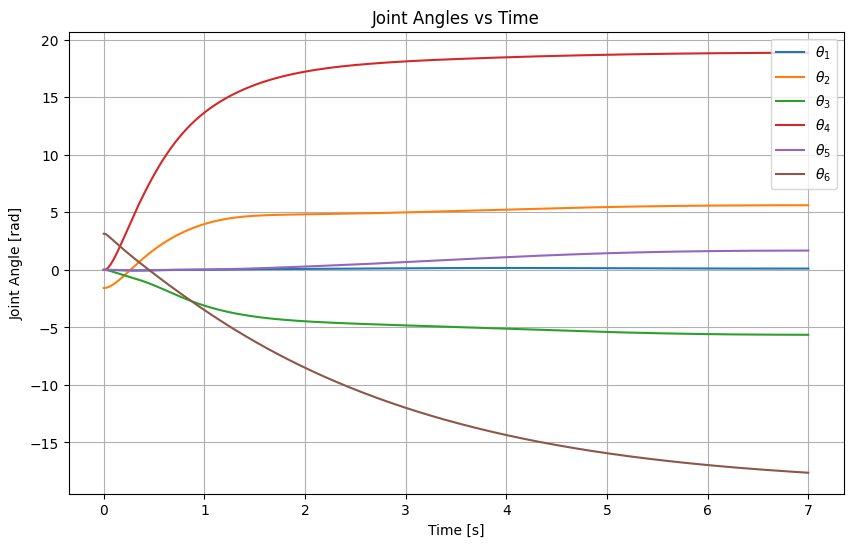

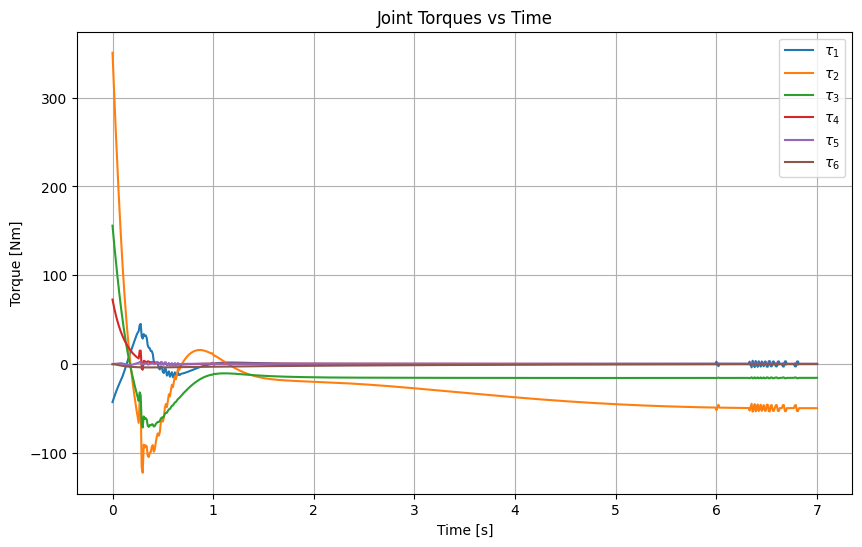

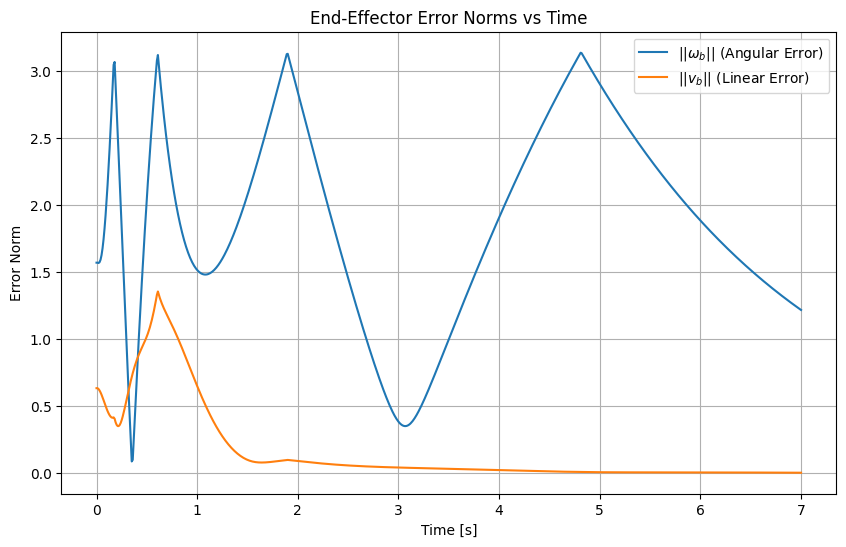


Running example in /Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/Example2
[simulate_ur5] N = 701, Tf = 7.0, dt = 0.01
IK step 0: success=True
[init_controller] Using Kp, Kd, Ki: 16.0 2.0 0.0
[simulate_ur5] t = 0.00, ||omega_b|| = 1.5700, ||v_b|| = 0.6335
[simulate_ur5] t = 0.70, ||omega_b|| = 0.1279, ||v_b|| = 0.3634
[simulate_ur5] t = 1.40, ||omega_b|| = 2.2200, ||v_b|| = 0.6232
[simulate_ur5] t = 2.10, ||omega_b|| = 1.6971, ||v_b|| = 0.0432
[simulate_ur5] t = 2.80, ||omega_b|| = 0.3808, ||v_b|| = 0.1203
[simulate_ur5] t = 3.50, ||omega_b|| = 2.2849, ||v_b|| = 0.1520
[simulate_ur5] t = 4.20, ||omega_b|| = 2.9946, ||v_b|| = 0.1123
[simulate_ur5] t = 4.90, ||omega_b|| = 2.0659, ||v_b|| = 0.0425
[simulate_ur5] t = 5.60, ||omega_b|| = 1.4401, ||v_b|| = 0.0244
[simulate_ur5] t = 6.30, ||omega_b|| = 0.9994, ||v_b|| = 0.0044
[simulate_ur5] t = 7.00, ||omega_b|| = 0.6918, ||v_b|| = 0.0022
Saved CSVs to directory: /Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/Example

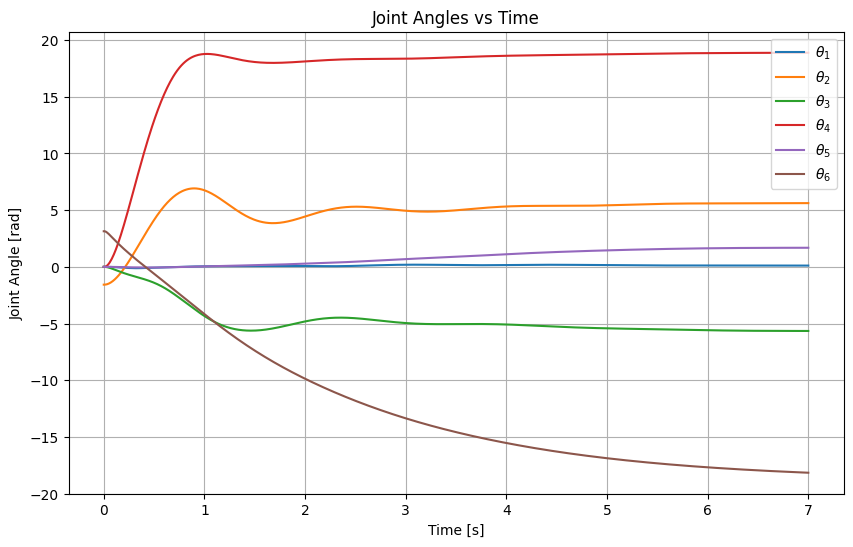

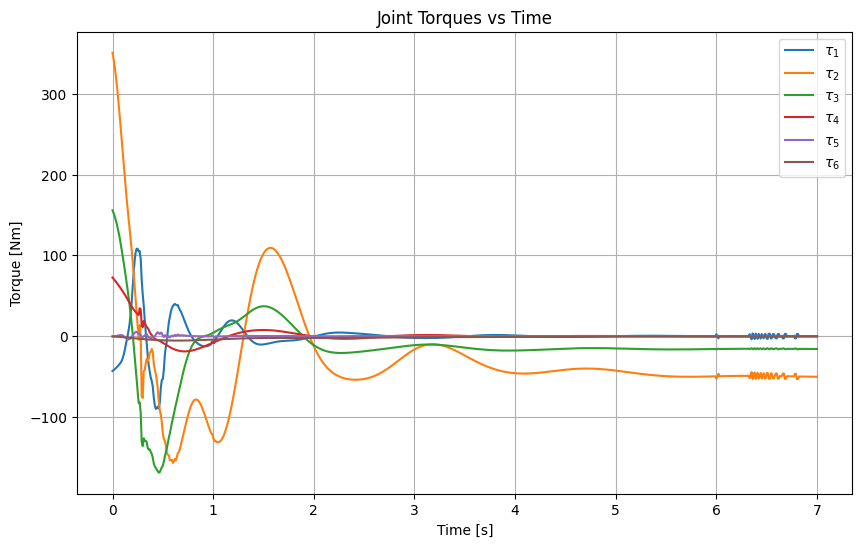

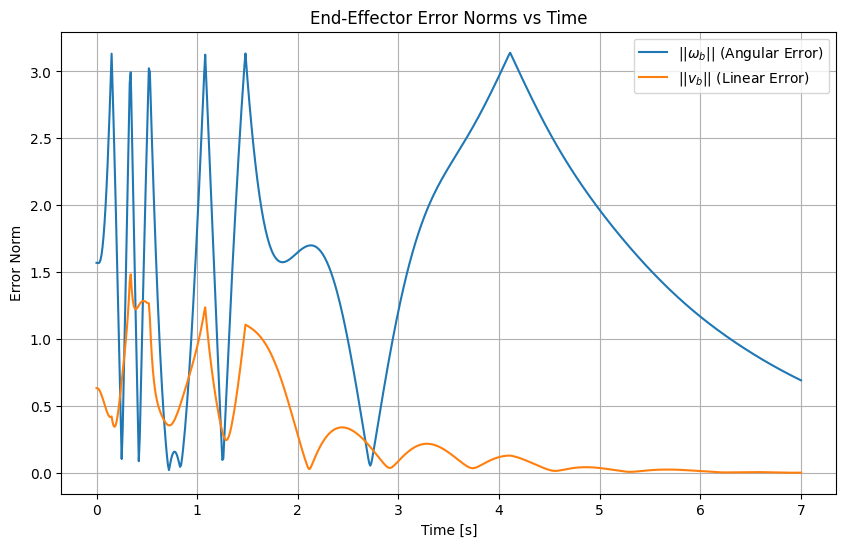


Running example in /Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/Example3
[simulate_ur5] N = 701, Tf = 7.0, dt = 0.01
IK step 0: success=True
[init_controller] Using Kp, Kd, Ki: 16.0 8.0 0.0
[simulate_ur5] t = 0.00, ||omega_b|| = 1.5700, ||v_b|| = 0.6335
[simulate_ur5] t = 0.70, ||omega_b|| = 1.3954, ||v_b|| = 0.6495
[simulate_ur5] t = 1.40, ||omega_b|| = 1.8264, ||v_b|| = 1.3287
[simulate_ur5] t = 2.10, ||omega_b|| = 2.7410, ||v_b|| = 1.2020
[simulate_ur5] t = 2.80, ||omega_b|| = 2.7581, ||v_b|| = 1.8406
[simulate_ur5] t = 3.50, ||omega_b|| = 1.0782, ||v_b|| = 1.3263
[simulate_ur5] t = 4.20, ||omega_b|| = 2.4576, ||v_b|| = 1.3847
[simulate_ur5] t = 4.90, ||omega_b|| = 3.0745, ||v_b|| = 1.8556
[simulate_ur5] t = 5.60, ||omega_b|| = 2.0203, ||v_b|| = 0.9707
[simulate_ur5] t = 6.30, ||omega_b|| = 1.6885, ||v_b|| = 1.5049
[simulate_ur5] t = 7.00, ||omega_b|| = 1.1863, ||v_b|| = 1.0479
Saved CSVs to directory: /Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/Example

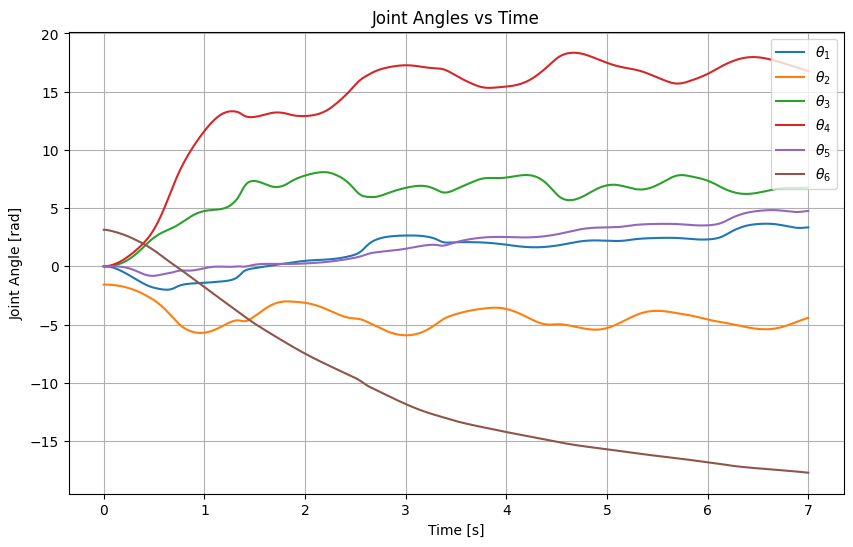

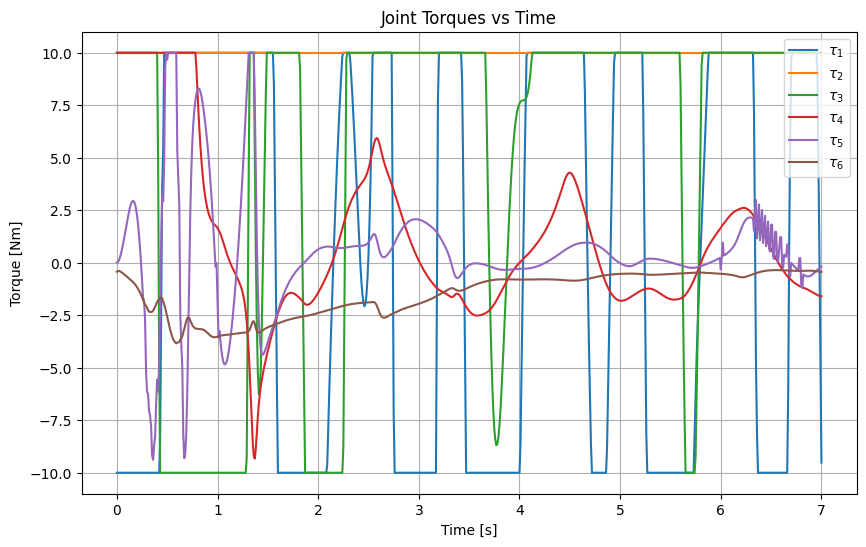

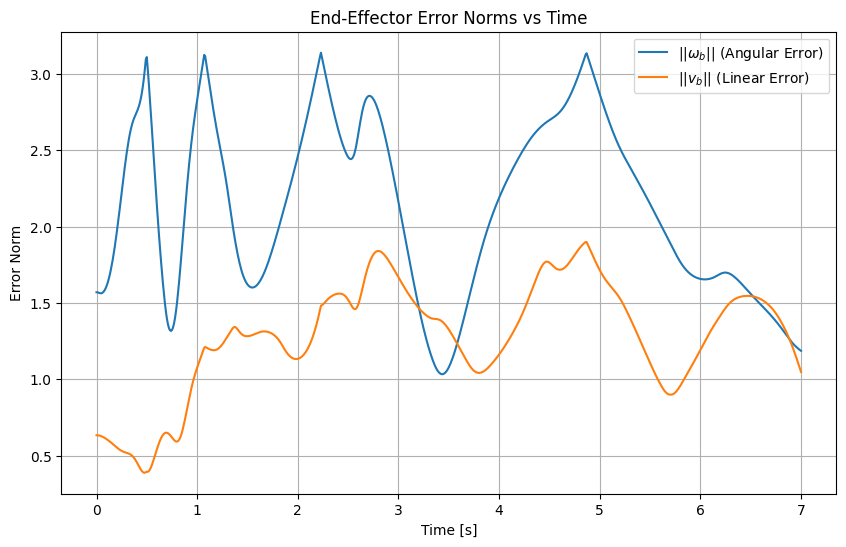


All examples completed


In [62]:
base_dir = "/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6"
example_dirs = [
    os.path.join(base_dir, "Example1"),
    os.path.join(base_dir, "Example2"),
    os.path.join(base_dir, "Example3"),
]
print("\nRunning all examples")
for ex_dir in example_dirs:
    run_example_folder(ex_dir, save_figs=True, show_figs=True)
print("\nAll examples completed")

### Appendix - Helper Functions for Testing

In [ ]:
def test_forward_kinematics():
    """
    Quick self-test: compute the forward kinematics at zero joint angles.
    """
    M, Mlist, Glist, Slist, g, Ftip = ur5_params()

    # Zero joint angles (home configuration)
    thetalist = np.zeros(6)

    # Forward kinematics in the space frame
    T = mr.FKinSpace(M, Slist, thetalist)

    print("Home configuration M (computed from Mlist):")
    print(M)
    print("\nForward kinematics at theta = 0 (should equal M):")
    print(T)
    print("\nDifference T - M:")
    print(T - M)

In [ ]:
def test_parse_input():
    """
    Test for the parse_input function.
    """
    example_path = "/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/input.txt"
    if not os.path.isfile(example_path):
        print(f"Please provide txt input path: {example_path}.")
        return

    cfg = parse_input(example_path)
    print("Parsed config keys:", cfg.keys())
    print("Ts_start:\n", cfg["Ts_start"])
    print("Ts_end:\n", cfg["Ts_end"])
    print("traj_type:", cfg["traj_type"])
    print("Tf:", cfg["Tf"])
    print("theta0:", cfg["theta0"])

In [ ]:
def test_generate_task_trajectory():
    """
    Test for generate_task_trajectory:
    - Parses input.txt
    - Generates a trajectory
    - Prints basic info
    """
    example_path = "/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/input.txt"
    if not os.path.isfile(example_path):
        print(f"Please create {example_path} first.")
        return

    # Parse config
    cfg = parse_input(example_path)

    # Generate trajectory
    dt = 0.01
    t_vec, Xd_list = generate_task_trajectory(cfg, dt=dt)

    print(f"Trajectory type: {cfg['traj_type']}")
    print(f"Tf = {cfg['Tf']}, dt = {dt}, N = {len(t_vec)}")
    print("First Xd (t=0):\n", Xd_list[0])
    print("Last  Xd (t=Tf):\n", Xd_list[-1])

In [ ]:
def test_compute_joint_reference():
    """
    Test of compute_joint_reference:
    - Parses nput.txt
    - Generates Xd(t)
    - Runs IK to get theta_d(t)
    - Checks that FKinSpace(theta_d[0]) and theta_d[-1] match Ts_start/Ts_end reasonably.
    """
    example_path = "/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/input.txt"
    if not os.path.isfile(example_path):
        print(f"Please create {example_path}")
        return

    cfg = parse_input(example_path)
    dt = 0.01
    t_vec, Xd_list = generate_task_trajectory(cfg, dt=dt)

    theta_d, dtheta_d, ddtheta_d = compute_joint_reference(cfg, t_vec, Xd_list,
                                                           ik_0=None,
                                                           verbose=True)

    print(f"theta_d shape: {theta_d.shape}")
    print("theta_d[0]:", theta_d[0])
    print("theta_d[-1]:", theta_d[-1])

    # Check forward kinematics at start and end
    M, Mlist, Glist, Slist, g, Ftip = ur5_params()
    X0_fk = mr.FKinSpace(M, Slist, theta_d[0])
    XN_fk = mr.FKinSpace(M, Slist, theta_d[-1])

    print("FK at theta_d[0]:\n", X0_fk)
    print("FK at theta_d[-1]:\n", XN_fk)
    print("Desired Ts_start:\n", cfg["Ts_start"])
    print("Desired Ts_end:\n", cfg["Ts_end"])

In [ ]:
def test_controller_single_step():
    """
    Test for controller_computed_torque:
    - Uses cfg, trajectory, joint reference
    - Calls controller once at t=0
    """
    example_path = "/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/input.txt"
    if not os.path.isfile(example_path):
        print(f"Please create {example_path}.")
        return

    cfg = parse_input(example_path)
    dt = 0.01
    t_vec, Xd_list = generate_task_trajectory(cfg, dt=dt)
    theta_d, dtheta_d, ddtheta_d = compute_joint_reference(cfg, t_vec, Xd_list,
                                                           ik_0=None,
                                                           verbose=False)

    # Take time step k=0
    k = 0
    theta = cfg["theta0"]           # actual initial config (off-trajectory)
    dtheta = np.zeros(6)            # starting at rest
    theta_d_k = theta_d[k]
    dtheta_d_k = dtheta_d[k]
    ddtheta_d_k = ddtheta_d[k]

    ctrl = init_controller()
    tau_control, ctrl = controller_computed_torque(theta, dtheta,
                                                   theta_d_k, dtheta_d_k, ddtheta_d_k,
                                                   ctrl, dt,
                                                   g=None, Mlist=None, Glist=None, Slist=None)
    print("Controller torque at t=0:", tau_control)

In [ ]:
def test_simulation():
    """
    Test the full simulation pipeline for a single input.txt.
    """
    example_path = "/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/input.txt"
    if not os.path.isfile(example_path):
        print(f"Please create {example_path}.")
        return

    cfg = parse_input(example_path)

    dt = 0.01
    results = simulate_ur5(cfg, dt=dt, verbose=True)

    print("\nSimulation finished.")
    print("theta_hist shape:", results["theta_hist"].shape)
    print("tau_hist shape:", results["tau_hist"].shape)
    print("omega_err (first 5):", results["omega_err"][:5])
    print("v_err (first 5):", results["v_err"][:5])

In [ ]:
def test_save_csvs():
    """
    Run a simulation and save CSV outputs to './output_test'.
    """
    example_path = "/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/input.txt"
    if not os.path.isfile(example_path):
        print(f"Please create {example_path}.")
        return

    cfg = parse_input(example_path)
    dt = 0.01
    results = simulate_ur5(cfg, dt=dt, verbose=False)

    out_dir = "/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/output_test1"
    save_results_to_csv(results, out_dir, run_name="test1")

In [ ]:
# # Step 1 test:
# print("Testing UR5 FK")
# test_forward_kinematics()

# # Step 2 test:
# print("\nTesting input parser")
# test_parse_input()

# # Step 3 test:
# print("\nTesting task-space trajectory generation")
# test_generate_task_trajectory()

# # Step 4 test:
# print("\n Testing joint-space reference generation")
# test_compute_joint_reference()

# # Step 5 test:
# print("\nTesting controller single step")
# test_controller_single_step()

# # Step 6 test:
# print("\nTesting full simulation")
# test_simulation()

# # Step 7 test:
# print("Running full simulation and saving CSVs")
# example_path = ("/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/input_test.txt")
# if os.path.isfile(example_path):
#     cfg = parse_input(example_path)
#     results = simulate_ur5(cfg, dt=None, verbose=True)
#     save_results_to_csv(results, "output_test75", run_name="test75")
# else:
#     print("Example input.txt not found")

Running full simulation and saving CSVs
[simulate_ur5] N = 701, Tf = 7.0, dt = 0.01
IK step 0: success=True
[init_controller] Using Kp, Kd, Ki: 16.0 8.0 0.0
[simulate_ur5] t = 0.00, ||omega_b|| = 1.5700, ||v_b|| = 0.6335
[simulate_ur5] t = 0.70, ||omega_b|| = 2.4659, ||v_b|| = 1.1801
[simulate_ur5] t = 1.40, ||omega_b|| = 1.8545, ||v_b|| = 0.1454
[simulate_ur5] t = 2.10, ||omega_b|| = 2.5548, ||v_b|| = 0.0819
[simulate_ur5] t = 2.80, ||omega_b|| = 0.7275, ||v_b|| = 0.0462
[simulate_ur5] t = 3.50, ||omega_b|| = 0.9980, ||v_b|| = 0.0318
[simulate_ur5] t = 4.20, ||omega_b|| = 2.2397, ||v_b|| = 0.0175
[simulate_ur5] t = 4.90, ||omega_b|| = 3.0293, ||v_b|| = 0.0074
[simulate_ur5] t = 5.60, ||omega_b|| = 2.2432, ||v_b|| = 0.0055
[simulate_ur5] t = 6.30, ||omega_b|| = 1.6530, ||v_b|| = 0.0047
[simulate_ur5] t = 7.00, ||omega_b|| = 1.2170, ||v_b|| = 0.0027
Saved CSVs to directory: output_test75
Scene2 file: output_test75/test75_scene2.csv
Joint angles: output_test75/test75_joint_angles.csv
Joi

#### Example Trajectories

In [ ]:
cfg = parse_input("/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/input.txt")
print_fk_of_theta0(cfg)

FK(theta0) =
[[-1.00000000e+00 -9.42939756e-21  0.00000000e+00  3.92588439e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.91450000e-01]
 [ 9.42939756e-21  1.00000000e+00  0.00000000e+00  4.19508865e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Equivalent Ts_start vector:  0.39258843885206174 0.19145 0.4195088652460297 0.0 2.221441469079183 2.221441469079183
Equivalent Ts_end vector:  0.39258843885206174 0.19145 0.4195088652460297 1.2091995761561452 1.2091995761561454 1.2091995761561454


In [ ]:
M, Mlist, Glist, Slist, g, Ftip = ur5_params()
theta0 = cfg["theta0"]

# Test IK for Ts_start
Ts_start = cfg["Ts_start"]
theta_sol_start, success_start = mr.IKinSpace(Slist, M, Ts_start, theta0, 1e-3, 1e-3)
print("IK for Ts_start success:", success_start)

# Test IK for Ts_end
Ts_end = cfg["Ts_end"]
theta_sol_end, success_end = mr.IKinSpace(Slist, M, Ts_end, theta0, 1e-3, 1e-3)
print("IK for Ts_end success:", success_end)

IK for Ts_start success: True
IK for Ts_end success: True


In [ ]:
def make_exampleA_Ts(theta0):
    M, Mlist, Glist, Slist, g, Ftip = ur5_params()
    X0 = mr.FKinSpace(M, Slist, theta0)
    R0, p0 = mr.TransToRp(X0)

    print("X0 (start pose):")
    print(X0)

    # Build X_end = "reach forward and down, tilt down"
    # 1) Choose a world-axis rotation: 90° about the world y-axis
    axis_y = np.array([0.0, 1.0, 0.0])   # adjust if needed
    angle = -np.pi / 2                   # 90° downward

    R_delta = mr.MatrixExp3(mr.VecToso3(axis_y * angle))
    R_end = R0 @ R_delta

    # 2) Shift position: e.g., 20cm forward in x, 15cm down in z
    p_shift = np.array([0.20, 0.0, -0.15])
    p_end = p0 + p_shift

    X_end = mr.RpToTrans(R_end, p_end)

    # Convert R0 and R_end to exponential coordinates for input.txt
    wtheta_start = mr.so3ToVec(mr.MatrixLog3(R0))
    wtheta_end   = mr.so3ToVec(mr.MatrixLog3(R_end))

    print("\nEquivalent Ts_start vector:")
    print(" ", p0[0], p0[1], p0[2],
           wtheta_start[0], wtheta_start[1], wtheta_start[2])

    print("\nEquivalent Ts_end vector (Example A):")
    print(" ", p_end[0], p_end[1], p_end[2],
           wtheta_end[0], wtheta_end[1], wtheta_end[2])

In [ ]:
cfg = parse_input("/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/input.txt")  # the old version or any
theta0 = cfg["theta0"]
make_exampleA_Ts(theta0)

X0 (start pose):
[[-1.00000000e+00 -9.42939756e-21  0.00000000e+00  3.92588439e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.91450000e-01]
 [ 9.42939756e-21  1.00000000e+00  0.00000000e+00  4.19508865e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Equivalent Ts_start vector:
  0.39258843885206174 0.19145 0.4195088652460297 0.0 2.221441469079183 2.221441469079183

Equivalent Ts_end vector (Example A):
  0.5925884388520617 0.19145 0.2695088652460297 1.2091995761561452 1.2091995761561454 1.2091995761561454


In [ ]:
def make_exampleB_Ts(theta0):
    M, Mlist, Glist, Slist, g, Ftip = ur5_params()
    X0 = mr.FKinSpace(M, Slist, theta0)
    R0, p0 = mr.TransToRp(X0)

    print("X0 (start pose):")
    print(X0)

    # Build X_end = "reach forward and down, tilt down"
    # 1) Choose a world-axis rotation: 90° about the world y-axis
    axis_y = np.array([0.0, 1.0, 0.0])   # adjust if needed
    angle = -np.pi / 2                   # 90° downward

    R_delta = mr.MatrixExp3(mr.VecToso3(axis_y * angle))
    R_end = R0 @ R_delta

    # 2) Shift position: e.g., 40cm forward in x, 15cm down in z
    p_shift = np.array([0.40, 0.0, -0.15])
    p_end = p0 + p_shift

    X_end = mr.RpToTrans(R_end, p_end)

    # Convert R0 and R_end to exponential coordinates for input.txt
    wtheta_start = mr.so3ToVec(mr.MatrixLog3(R0))
    wtheta_end   = mr.so3ToVec(mr.MatrixLog3(R_end))

    print("\nEquivalent Ts_start vector:")
    print(" ", p0[0], p0[1], p0[2],
           wtheta_start[0], wtheta_start[1], wtheta_start[2])

    print("\nEquivalent Ts_end vector (Example B):")
    print(" ", p_end[0], p_end[1], p_end[2],
           wtheta_end[0], wtheta_end[1], wtheta_end[2])

In [ ]:
cfg = parse_input("/Users/kaanborekci/Desktop/ME-449/Assignments/Assignment-6/input.txt")  # the old version or any
theta0 = cfg["theta0"]
make_exampleB_Ts(theta0)

X0 (start pose):
[[-1.00000000e+00 -9.42939756e-21  0.00000000e+00  3.92588439e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.91450000e-01]
 [ 9.42939756e-21  1.00000000e+00  0.00000000e+00  4.19508865e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Equivalent Ts_start vector:
  0.39258843885206174 0.19145 0.4195088652460297 0.0 2.221441469079183 2.221441469079183

Equivalent Ts_end vector (Example B):
  0.7925884388520618 0.19145 0.2695088652460297 1.2091995761561452 1.2091995761561454 1.2091995761561454
